In [6]:
BASIN = "calpella"
MODE = "daily"     
RUN_LABEL = "BASELINE"
READ_STAMP = "20250815T000000Z"

NEW_DATA_DIR = "/Users/canruso/Desktop/UCB-USACE-RR-PROJECT/russian_river_data/synthetic/calpella/fake_shift4y_dry_peaky"

TEST_START_DATE = "01/10/2009"   
TEST_END_DATE   = "29/09/2013"

PERIOD = "test"
EPOCH = None
GPU_SETTING = -1
AGG = "1D" if MODE == "daily" else "1H"

##### NOTE! The data should be called daily_shift.csv or hourly_shift.csv depending on the MODE,
##### AND the physics data file should be called physics_daily.csv OR physics_hourly.csv depending on the MODE.

In [7]:
import os, sys
from pathlib import Path
import pandas as pd

library_path = os.path.join('..', '..', '..', 'UCB-USACE-RR-PROJECT')
sys.path.insert(0, library_path)

from neuralhydrology.utils.config import Config

from UCB_training.UCB_utils import (set_active_context, ensure_shared_tree, ensure_output_tree, runs_latest_path, resolve_run_dirs, prepare_out_path)
from UCB_training.UCB_eval import (make_eval_config, evaluate_runs_on_new_data, collect_predictions, save_predictions)

from UCB_training.UCB_plotting import plot_forecasts

In [3]:
set_active_context(basin=BASIN, resolution=MODE, run_stamp=READ_STAMP, run_tag=RUN_LABEL, append_stamp_to_filenames=False)

SHARED = ensure_shared_tree(BASIN, MODE)
if MODE != "mts":
    ensure_output_tree(BASIN, MODE)

RUNS_FILE = (SHARED / "runs" / "archive" / f"{BASIN}_{MODE}_{RUN_LABEL}_stored_runs_{READ_STAMP}.json" if READ_STAMP else runs_latest_path(BASIN, MODE, RUN_LABEL))

runs = resolve_run_dirs(RUNS_FILE, basin=BASIN, mode=MODE, label=RUN_LABEL, stamp=READ_STAMP)
no_phys_dirs = [Path(p) for p in runs.get("no_physics", [])]
phys_dirs = [Path(p) for p in runs.get("physics", [])]

if not no_phys_dirs and not phys_dirs:
    raise FileNotFoundError(f"No runs in {RUNS_FILE}")

print("no_physics:", [p.name for p in no_phys_dirs])
print("physics:", [p.name for p in phys_dirs])

no_physics: ['testing_run_2906_213715']
physics   : ['testing_run_2906_213838']


In [4]:
NEW_DATA_DIR = Path(NEW_DATA_DIR).resolve()
cfg_builder = lambda rd, **kw: make_eval_config(rd, basin=BASIN, data_dir=NEW_DATA_DIR, **kw)

if no_phys_dirs:
    ep = EPOCH if EPOCH is not None else Config(no_phys_dirs[0] / "config.yml").epochs
    evaluate_runs_on_new_data(no_phys_dirs, cfg_builder=cfg_builder, period=PERIOD, start_date=TEST_START_DATE, end_date=TEST_END_DATE, gpu=GPU_SETTING, epoch=EPOCH)
    
if phys_dirs:
    ep_ph = EPOCH if EPOCH is not None else Config(phys_dirs[0] / "config.yml").epochs
    evaluate_runs_on_new_data(phys_dirs, cfg_builder=cfg_builder, period=PERIOD, start_date=TEST_START_DATE, end_date=TEST_END_DATE, gpu=GPU_SETTING, epoch=EPOCH)
print("Evaluation complete.")

lstm_csv = pilstm_csv = None
if no_phys_dirs:
    ep = EPOCH if EPOCH is not None else Config(no_phys_dirs[0] / "config.yml").epochs
    df_lstm = collect_predictions(no_phys_dirs, period=PERIOD, epoch=ep, agg=AGG, colname="LSTM_Predicted")
    lstm_csv = save_predictions(df_lstm[["Date","LSTM_Predicted"]], basin=BASIN, mode=MODE, period=PERIOD, tag="LSTM", filename_suffix="forecast")
if phys_dirs:
    ep = EPOCH if EPOCH is not None else Config(phys_dirs[0] / "config.yml").epochs
    df_pil = collect_predictions(phys_dirs, period=PERIOD, epoch=ep, agg=AGG, colname="PLSTM_Predicted")
    pilstm_csv = save_predictions(df_pil[["Date","PLSTM_Predicted"]], basin=BASIN, mode=MODE, period=PERIOD, tag="PILSTM", filename_suffix="forecast")

/Users/canruso/Desktop/UCB-USACE-RR-PROJECT/notebooks/reload_predict_new_data/../../../UCB-USACE-RR-PROJECT/neuralhydrology/evaluation/tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this e

Evaluation complete.


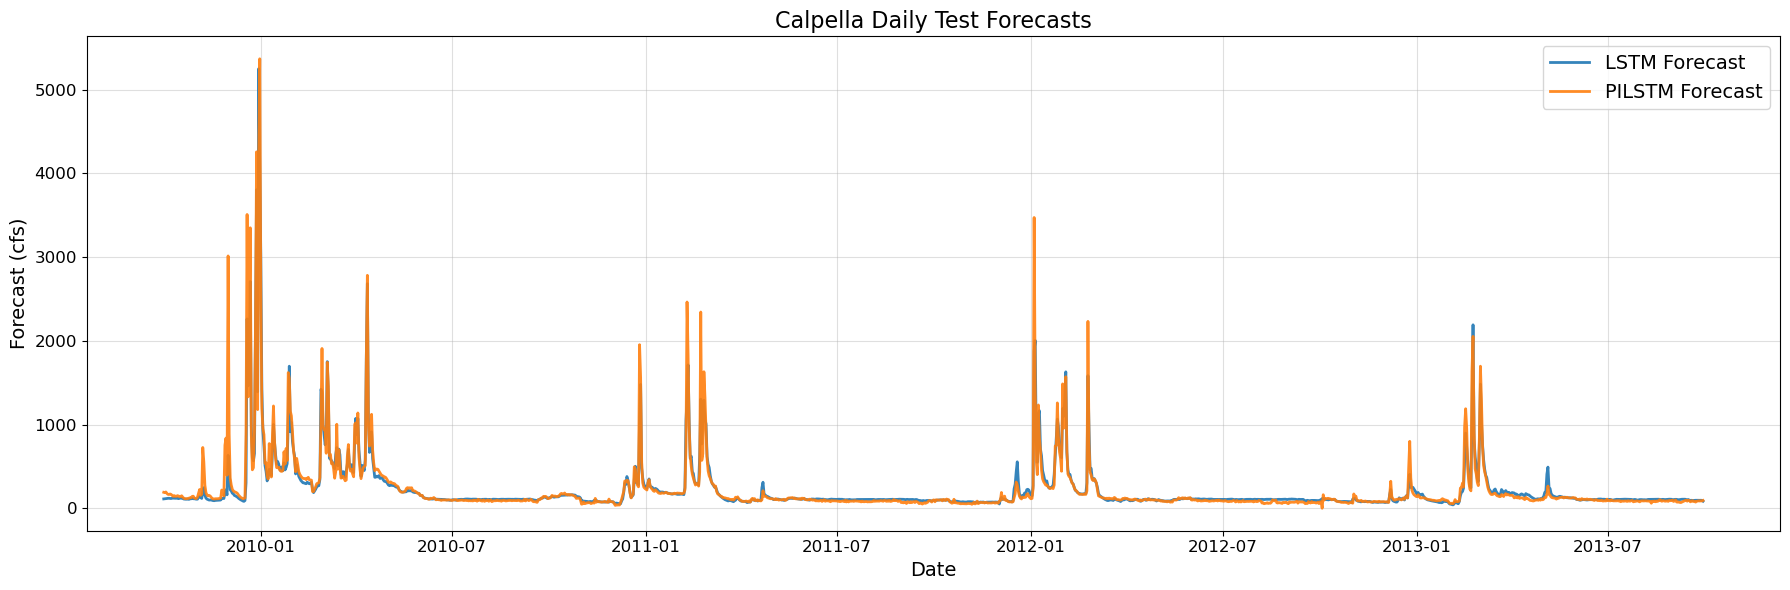

In [5]:
srcs = []
if lstm_csv: srcs.append(lstm_csv)
if pilstm_csv: srcs.append(pilstm_csv)

if len(srcs) == 1:
    df1 = pd.read_csv(srcs[0]); df1["Date"] = pd.to_datetime(df1["Date"], errors="coerce")
    if "Predicted" in df1.columns: df1.rename(columns={"Predicted":"LSTM_Predicted"}, inplace=True)
    plot_forecasts(df1, title=f"{BASIN.capitalize()} {MODE.capitalize()} {PERIOD.capitalize()} Forecast", start_date=TEST_START_DATE, end_date=TEST_END_DATE, fig_out=f"{BASIN}_{MODE}_{PERIOD}_forecast.png", ts_out=f"{BASIN}_{MODE}_{PERIOD}_forecast_ts.csv", period=PERIOD)
else:
    plot_forecasts(tuple(srcs), title=f"{BASIN.capitalize()} {MODE.capitalize()} {PERIOD.capitalize()} Forecasts", start_date=TEST_START_DATE, end_date=TEST_END_DATE, fig_out=f"{BASIN}_{MODE}_{PERIOD}_forecasts.png", ts_out=f"{BASIN}_{MODE}_{PERIOD}_forecasts_ts.csv", period=PERIOD)